In [1]:
import sys
sys.path.append("../")
import spopt


exact solver


In [2]:
import geopandas as gpd

In [3]:
gdf = gpd.read_file('../spopt/data/n100.shp')

In [4]:
gdf.head()

,ID,SAR1,Uniform2,geometry
0,0.0,-1.039542,14.817274,"POLYGON ((0.000 100.000, 10.000 100.000, 10.00..."
1,1.0,-0.587864,11.454981,"POLYGON ((10.000 100.000, 20.000 100.000, 20.0..."
2,2.0,0.853925,12.829352,"POLYGON ((20.000 100.000, 30.000 100.000, 30.0..."
3,3.0,1.520132,12.445755,"POLYGON ((30.000 100.000, 40.000 100.000, 40.0..."
4,4.0,0.949061,10.322907,"POLYGON ((40.000 100.000, 50.000 100.000, 50.0..."


In [5]:
from spopt import MaxPHeuristic as MaxP

In [6]:
import libpysal

In [7]:
w = libpysal.weights.Rook.from_dataframe(gdf)

In [8]:
attrs_name = ['SAR1']
threshold_name = 'Uniform2'
threshold = 100
top_n = 2


In [9]:
model = MaxP(gdf, w, attrs_name, threshold_name, threshold, top_n)

In [10]:
model

In [11]:
dir(model)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 'attrs_name',
 'gdf',
 'max_iterations_construction',
 'max_iterations_sa',
 'solve',
 'threshold',
 'threshold_name',
 'top_n',
 'w']

In [12]:
model.solve()

spatialAttrTotal, LabelID  (108.0712383, [24, 25, 34, 14, 23, 26, 35, 15, 33])
spatialAttrTotal, LabelID  (112.70958610000001, [48, 49, 58, 38, 47, 59, 39, 57, 68])
spatialAttrTotal, LabelID  (102.2520588, [88, 89, 98, 78, 87, 99, 79, 97])
spatialAttrTotal, LabelID  (107.3469749, [46, 56, 36, 45, 66, 55, 37, 44, 65])
spatialAttrTotal, LabelID  (110.62382369999999, [0, 1, 10, 2, 11, 20, 3, 12, 21])
spatialAttrTotal, LabelID  (107.6770381, [91, 81, 90, 92, 80, 82, 71, 93, 70])
spatialAttrTotal, LabelID  (101.40380289999999, [75, 74, 76, 85, 64, 73, 84, 77, 86])
spatialAttrTotal, LabelID  (110.59441379999998, [19, 9, 18, 29, 8, 17, 28, 7, 16])
spatialAttrTotal, LabelID  (38.200015699999994, [96, 95, 94])
spatialAttrTotal, LabelID  (110.49741089999999, [31, 32, 41, 30, 42, 22, 40, 51, 43])
spatialAttrTotal, LabelID  (109.5564249, [61, 60, 62, 50, 72, 52, 63, 53, 54])
spatialAttrTotal, LabelID  (35.6320672, [4, 5, 6])
spatialAttrTotal, LabelID  (13.9311005, [13])
spatialAttrTotal, LabelID  

spatialAttrTotal, LabelID  (104.390935, [26, 16, 25, 27, 36, 17, 6, 15, 24])
spatialAttrTotal, LabelID  (102.2520588, [88, 89, 98, 78, 87, 99, 79, 97])
spatialAttrTotal, LabelID  (112.3164302, [10, 0, 11, 20, 1, 30, 40, 41, 50])
spatialAttrTotal, LabelID  (63.7744795, [85, 86, 95, 96, 94])
spatialAttrTotal, LabelID  (97.4274113, [8, 9, 18, 7, 19, 28, 29, 39])
spatialAttrTotal, LabelID  (102.6120411, [44, 34, 43, 45, 54, 35, 53, 52])
spatialAttrTotal, LabelID  (62.858093200000006, [5, 4, 3, 14, 13])
spatialAttrTotal, LabelID  (112.2885298, [60, 61, 70, 51, 62, 71, 80, 90, 91])
spatialAttrTotal, LabelID  (11.3493694, [77])
spatialAttrTotal, LabelID  (11.0213024, [92])
spatialAttrTotal, LabelID  (12.6002124, [37])
spatialAttrTotal, LabelID  (14.7819167, [69])
spatialAttrTotal, LabelID  (106.01364, [21, 11, 20, 22, 31, 1, 10, 12, 30])
spatialAttrTotal, LabelID  (100.61251209999999, [57, 56, 58, 67, 47, 66, 46, 55])
spatialAttrTotal, LabelID  (103.3773068, [60, 50, 61, 70, 40, 51, 62, 71])


spatialAttrTotal, LabelID  (109.2422038, [40, 41, 50, 30, 42, 51, 31, 60, 20])
spatialAttrTotal, LabelID  (106.15758070000001, [54, 64, 44, 53, 55, 65, 74, 63, 34])
spatialAttrTotal, LabelID  (102.8806169, [87, 88, 97, 77, 86, 89, 98, 78])
spatialAttrTotal, LabelID  (108.8907714, [75, 76, 85, 66, 84, 95, 56, 67, 83])
spatialAttrTotal, LabelID  (112.70958610000001, [48, 49, 58, 38, 47, 59, 39, 57, 68])
spatialAttrTotal, LabelID  (100.72552069999999, [13, 3, 12, 14, 23, 2, 4, 11])
spatialAttrTotal, LabelID  (103.6054212, [92, 82, 91, 93, 72, 81, 90, 94, 73])
spatialAttrTotal, LabelID  (77.4737816, [52, 62, 61, 71, 70, 80])
spatialAttrTotal, LabelID  (103.49758190000001, [46, 36, 45, 26, 35, 37, 16, 25, 27])
spatialAttrTotal, LabelID  (36.944556500000004, [0, 1, 10])
spatialAttrTotal, LabelID  (112.25116229999999, [19, 9, 18, 29, 8, 17, 28, 7, 6])
spatialAttrTotal, LabelID  (61.634112800000004, [33, 32, 43, 22, 21])
spatialAttrTotal, LabelID  (23.1776195, [15, 5])
spatialAttrTotal, LabelI

totalWithinRegionDistance after SA: 
482.92670100000004
totalWithinRegionDistance after SA: 
567.59530291
totalWithinRegionDistance after SA: 
455.5452908
totalWithinRegionDistance after SA: 
440.40163471
totalWithinRegionDistance after SA: 
550.78062444
totalWithinRegionDistance after SA: 
456.44820290999996
totalWithinRegionDistance after SA: 
540.4245693500001
totalWithinRegionDistance after SA: 
542.6373895099999
totalWithinRegionDistance after SA: 
454.07135982
1
totalWithinRegionDistance after SA: 
571.2550971999999
totalWithinRegionDistance after SA: 
604.05690115
totalWithinRegionDistance after SA: 
567.3357744
totalWithinRegionDistance after SA: 
576.41090998
totalWithinRegionDistance after SA: 
580.8028329199999
totalWithinRegionDistance after SA: 
607.47159252
totalWithinRegionDistance after SA: 
571.51814513
totalWithinRegionDistance after SA: 
586.6190634300001
totalWithinRegionDistance after SA: 
511.24761635000004
totalWithinRegionDistance after SA: 
586.48909524
2
total

In [13]:
model.p

11

In [14]:
model.labels_

[3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 12,
 12,
 3,
 3,
 3,
 8,
 8,
 2,
 2,
 2,
 12,
 12,
 7,
 3,
 8,
 8,
 2,
 2,
 12,
 12,
 12,
 12,
 7,
 6,
 8,
 8,
 8,
 8,
 8,
 12,
 10,
 10,
 7,
 6,
 6,
 6,
 4,
 4,
 4,
 10,
 10,
 10,
 7,
 6,
 6,
 6,
 4,
 1,
 1,
 10,
 10,
 10,
 7,
 9,
 6,
 4,
 4,
 4,
 1,
 1,
 5,
 10,
 7,
 9,
 9,
 9,
 4,
 1,
 1,
 1,
 5,
 5,
 7,
 7,
 9,
 9,
 4,
 1,
 1,
 5,
 5,
 5,
 7,
 9,
 9,
 9,
 1,
 1,
 1,
 1,
 5,
 5]

In [15]:
gdf['region11'] = model.labels_
gdf.to_file('region11.shp')

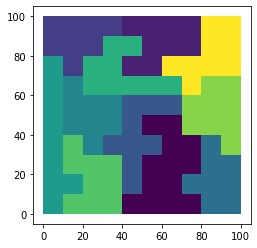

In [16]:
%matplotlib inline
gdf.plot(column='region11')